# Sentiment Analysis Pipeline for Word Dimensions

This project focuses on analyzing data from the CHILDES (Child Language Data Exchange System) corpus, specifically extracting utterances and analyzing their sentiment using natural language processing techniques. The analysis aims to uncover patterns in child language development and emotional context through comparing different sentiment analysis models.

## Data Cleaning

In [1]:
import nltk
import csv
import numpy as np
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)

In [2]:
def read_csv_column(file_path, row_start, row_end):
    data = []
    rowcount = 0
    with open(file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if rowcount >= row_start and rowcount < row_end:
                if len(row) > 7:
                    data.append(row[7]) # column 7 is the column for utterances
                    rowcount += 1
            elif rowcount >= row_end:
                break
            else: 
                rowcount+= 1
    return data

In [3]:
data = read_csv_column("eng-NA-all-utterances.csv", 1, 5)

## Finding Polarity

### DistilBERT

In [4]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
data = ["I feel good"]

for item in data:
    print(f"Text: {item}")
    result = sentiment_pipeline(item)
    print(f"Sentiment: {result[0]['label']}, Confidence: {result[0]['score']:.4f}\n")

/Users/tvidyala/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Text: I feel good
Sentiment: POSITIVE, Confidence: 0.9999



### NTLK

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
data = ["i feel happy"] 
for item in data:
    print(item)
    print(f"{sentiment_pipeline(item)}\n")
    print(f"{analyzer.polarity_scores(item)}\n")

i feel happy
[{'label': 'POSITIVE', 'score': 0.999883770942688}]

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}



# Finding Valence, Arousal, and Dominance

This tool calculates Valence-Arousal-Dominance (VAD) scores for utterances in a CSV file, accounting for polarity shifts from negations (like "no" or "not"), and outputs a new CSV with the utterances, speaker data, and their computed VAD scores for further analysis.

In [6]:
def VAD(text, vad_scores):
    i, j = 0, 0
    text_vad = np.zeros([3,])
    for word in text.split(' '):
        neg = 1  # reverse polarity for this word
        if word in vad_scores.index:
            if 'no' in text.split(' ')[max(0, j-6):j] or 'not' in text.split(' ')[max(0, j-6):j] or 'n\'t' in str(text.split(' ')[max(0, j-3):j]):
                neg = -1
            text_vad = vad_scores.loc[word] * neg + text_vad
            i += 1
        j += 1
    return text_vad / i

def read_csv_column(file_path, row_start, row_end, column_index):
    data = []
    rowcount = 0
    with open(file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if rowcount >= row_start and rowcount < row_end:
                if len(row) > column_index:
                    data.append(row[column_index])
                rowcount += 1
            elif rowcount >= row_end:
                break
            else: 
                rowcount += 1
    return data

data = read_csv_column("Laura.csv", 1, 77136, 8) 
speaker_data = read_csv_column("Laura.csv", 1, 77136, 4) 
filename_data = read_csv_column("Laura.csv", 1, 77136, 0)
age_data = read_csv_column("Laura.csv", 1, 77136, 11)

vad_scores = pd.read_csv("vad-nrc.csv", index_col='Word')
        
arousal_scores = []
valence_scores = []
dominance_scores = []

for text in data:
    vad = VAD(text, vad_scores)
    arousal_scores.append(vad[0])
    valence_scores.append(vad[1])
    dominance_scores.append(vad[2])

df = pd.DataFrame({
    'File Name': filename_data,
    'Utterance': data,
    'Speaker': speaker_data,
    'Age': age_data,
    'Arousal': arousal_scores,
    'Valence': valence_scores,
    'Dominance': dominance_scores
    
})

df.to_csv("/Users/tvidyala/Desktop/CHILDES/LauraVADScores.csv", index=False) # updates LauraVADScores with VAD Scores
df

/var/folders/ym/3kwq9dtj5914fkc699t0n4980000gn/T/ipykernel_42531/2111832172.py:12: RuntimeWarning: invalid value encountered in divide
  return text_vad / i


,File Name,Utterance,Speaker,Age,Arousal,Valence,Dominance
0,101907,yeah,MOT,1 Year 5 Months,NaN,NaN,NaN
1,101908,this is July thirtieth,MOT,1 Year 5 Months,NaN,NaN,NaN
2,101909,go,CHI,1 Year 5 Months,0.510000,0.4410,0.4440
3,101910,that's the recorder,MOT,1 Year 5 Months,0.551000,0.3740,0.4810
4,101911,that's correct,MOT,1 Year 5 Months,0.857000,0.3060,0.7230
...,...,...,...,...,...,...,...
77130,179037,no he isn't,CHI,,NaN,NaN,NaN
77131,179038,the old Gitta will be in the office right,CHI,,0.589000,0.3162,0.5646
77132,179039,yes I'll be in my office,FRI,,0.548500,0.2710,0.5315
77133,179040,do you want a new Gitta,FRI,,0.752667,0.5600,0.5720


# Finding Average Valence, Arousal, and Dominance for Child by Age

This tool calculates the average Valence, Arousal, and Dominance (VAD) scores of a child speaker's utterances grouped by age in months, then visualizes the trends of these scores over time in a line plot.

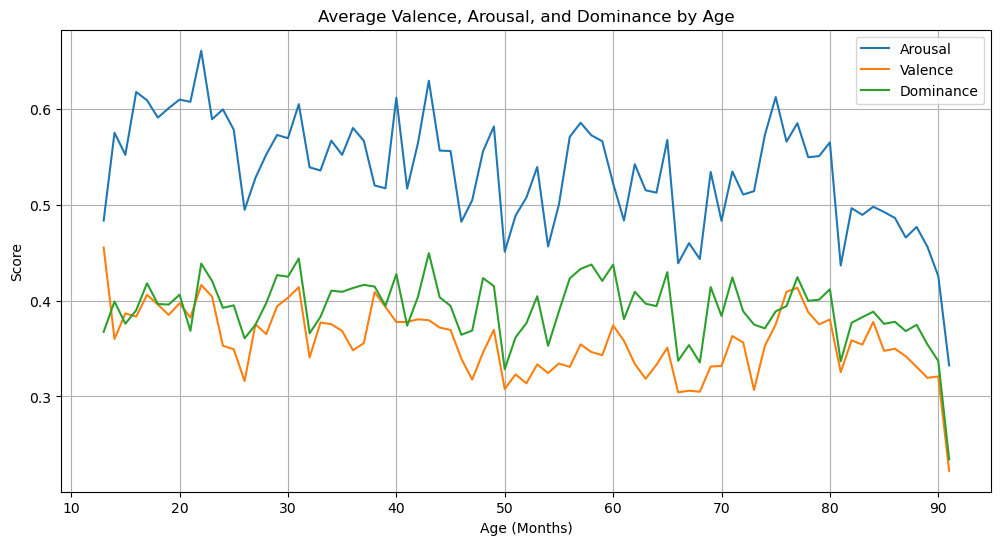

In [7]:
def extract_age_months(file_name):
    age_code = int(str(file_name)[:3])
    years = age_code // 100
    months = age_code % 100
    return years * 12 + months

df['Age (Months)'] = df['File Name'].apply(extract_age_months)

my_data = df[df['Speaker'] == 'CHI']

avg_vad_by_age = my_data.groupby('Age (Months)')[['Arousal', 'Valence', 'Dominance']].mean()

plt.figure(figsize=(12, 6))
for column in avg_vad_by_age.columns:
    plt.plot(avg_vad_by_age.index, avg_vad_by_age[column], label=column)

plt.title('Average Valence, Arousal, and Dominance by Age')
plt.xlabel('Age (Months)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

I noticed that there were a lot of neutral utterances being factored into this calculation, so I wrote a script to filter out utterances below a certain polarity threshold and redo the visualization.

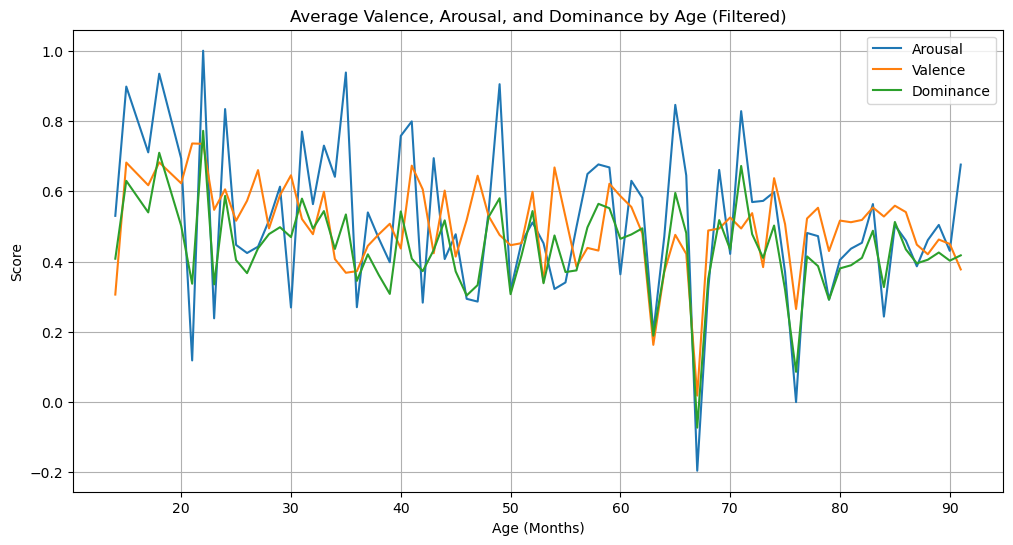

In [13]:
analyzer = SentimentIntensityAnalyzer()

df['Compound'] = df['Utterance'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
emotion_threshold = 0.5

my_data = df[(df['Speaker'] == 'CHI') & (df['Compound'].abs() > emotion_threshold)]

avg_vad_by_age = my_data.groupby('Age (Months)')[['Arousal', 'Valence', 'Dominance']].mean()

plt.figure(figsize=(12, 6))
for column in avg_vad_by_age.columns:
    plt.plot(avg_vad_by_age.index, avg_vad_by_age[column], label=column)

plt.title('Average Valence, Arousal, and Dominance by Age (Filtered)')
plt.xlabel('Age (Months)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()
